## 数値ハックについて

LBに効きそうなPPのアイデアについてのメモ。

In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))

[PosixPath('../../../input/hms-harmful-brain-activity-classification/test_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/example_figures'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/sample_submission.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train.csv')]

In [3]:
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)

## Vote数の合計値の分布

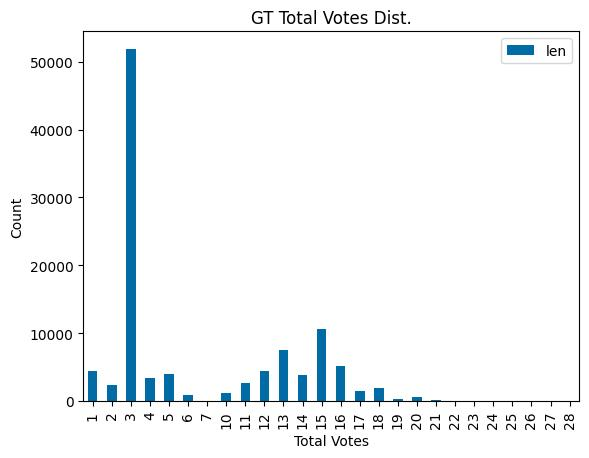

In [4]:
_, ax = plt.subplots()
metadata.group_by("total_votes").len().sort("total_votes").to_pandas().set_index(
    "total_votes"
).plot.bar(ax=ax)
ax.set(xlabel="Total Votes", ylabel="Count", title="GT Total Votes Dist.")
plt.show()

* trainではn=3が圧倒的に多いので、n=3の仮説に当てはまるサンプルはn=3で量子化すればCV/LB下がりそう。ただし、public discussionなどから判断すると、testにはlow-qualityのサンプル数が少なそう。

## GTの数値の分布

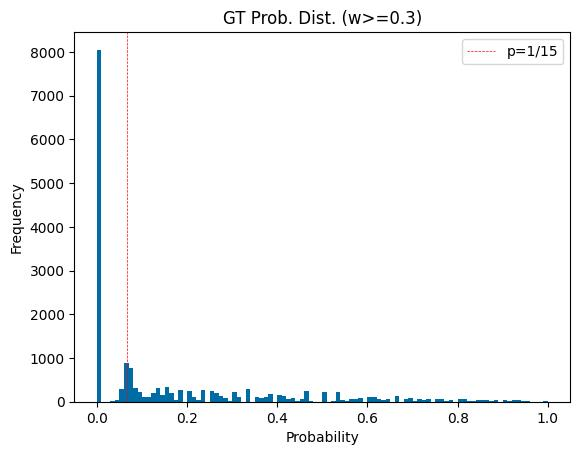

In [5]:
vote_variations = (
    (
        metadata.filter(pl.col("weight").ge(0.3))
        .select([f"{label}_prob" for label in LABELS])
        .unique()
        .with_columns([pl.col(f"{label}_prob") for label in LABELS])
    )
    .to_numpy()
    .flatten()
)
_, ax = plt.subplots()
ax.hist(vote_variations, bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="GT Prob. Dist. (w>=0.3)",
)
ax.axvline(1/15, color="red", linestyle="--", label="p=1/15", linewidth=0.5)
ax.legend()
plt.show()

* p=0のカラムが圧倒的に多いので、0に十分近いものは0で補正するとかはありそう
* high_qualityの分布を反映してか、p=1/15に小さなピークがある

## EEG単位の分析

In [6]:
eeg_df_with_id = (
    metadata.group_by("eeg_id")
    .agg(
        *[
            pl.col(f"{label}_prob_per_eeg").first().alias(f"{label}_prob")
            for label in LABELS
        ],
        pl.col("weight_per_eeg").first().alias("weight"),
    )
    .filter(pl.col("weight").ge(0.3))
    .drop("weight")
)
eeg_df = eeg_df_with_id.drop("eeg_id")
vote_variations_per_eeg = eeg_df.to_numpy().flatten()

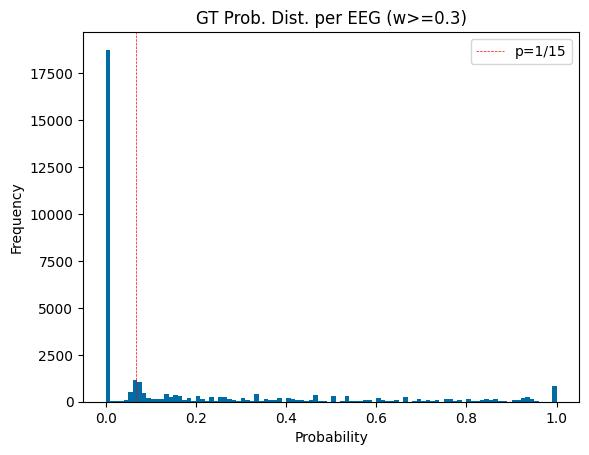

In [45]:
_, ax = plt.subplots()
ax.hist(vote_variations_per_eeg, bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="GT Prob. Dist. per EEG (w>=0.3)",
)
ax.axvline(1/15, color="red", linestyle="--", label="p=1/15", linewidth=0.5)
ax.legend()
plt.show()

* p=1にも小さなピークがある

## Max/Min確率の分布

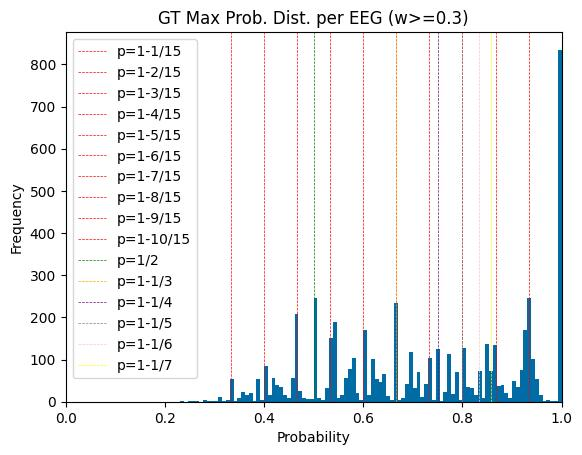

In [17]:
_, ax = plt.subplots()
ax.hist(eeg_df.to_numpy().max(axis=1), bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="GT Max Prob. Dist. per EEG (w>=0.3)",
    xlim=(0, 1),
)
for i in range(1, 11):
    ax.axvline(1-i/15, color="red", linestyle="--", label=f"p=1-{i}/15", linewidth=0.5)

ax.axvline(1/2, color="green", linestyle="--", label="p=1/2", linewidth=0.5)
ax.axvline(1-1/3, color="orange", linestyle="--", label="p=1-1/3", linewidth=0.5)
ax.axvline(1-1/4, color="purple", linestyle="--", label="p=1-1/4", linewidth=0.5)
ax.axvline(1-1/5, color="gray", linestyle="--", label="p=1-1/5", linewidth=0.5)
ax.axvline(1-1/6, color="pink", linestyle="--", label="p=1-1/6", linewidth=0.5)
ax.axvline(1-1/7, color="yellow", linestyle="--", label="p=1-1/7", linewidth=0.5)
ax.legend()
plt.show()

* Over-fitの可能性高まるが、Maxを1/15の等間隔のラインで近いところに補正するというのはありかも。

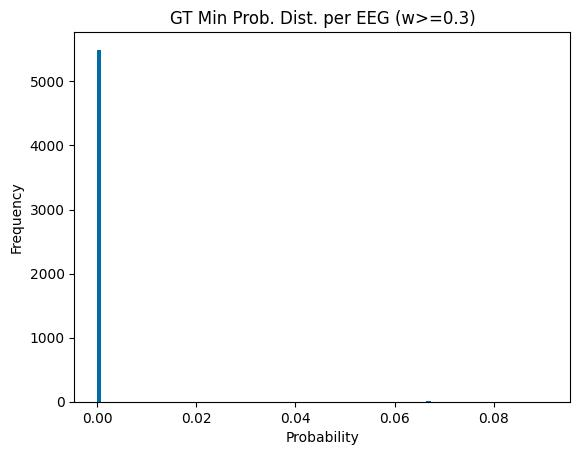

In [9]:
_, ax = plt.subplots()
ax.hist(eeg_df.to_numpy().min(axis=1), bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="GT Min Prob. Dist. per EEG (w>=0.3)",
)
plt.show()

## 量子化された確率の理論的なバリエーションについて

* n=3-20の間に、量子化された確率k/nにはどのようなバリエーションがあるか？

Possible Discrete Prob where n=3-20: 129


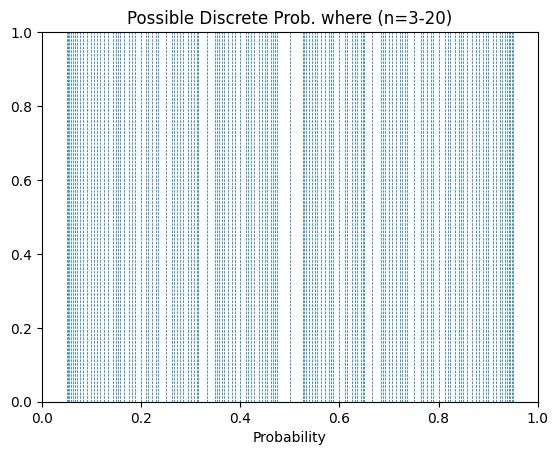

In [43]:
variations = set()
for n in range(3, 21):
    for k in range(0, n + 1):
        if k / n not in variations:
            variations.add(k / n)
print("Possible Discrete Prob where n=3-20:", len(variations))
_, ax = plt.subplots()
for x in variations:
    ax.axvline(x, 0, 1, linestyle="--", linewidth=0.5)

ax.set(xlabel="Probability", title="Possible Discrete Prob. where (n=3-20)")
plt.show()

* vote数が3-20と仮定した場合、1/6以上の量子化されたprobのとりうる値は129通りある。これらのいずれか近い値に補正する。
    - 特に、p=0.5は前後の間隔が空いているので補正の効果が高そう
    - [0, 1/20], [1-1/20, 1]の区間には理論的に値を取りえないので大きなギャップが空いている

## Modelの予測値の分布について

### Prob dist

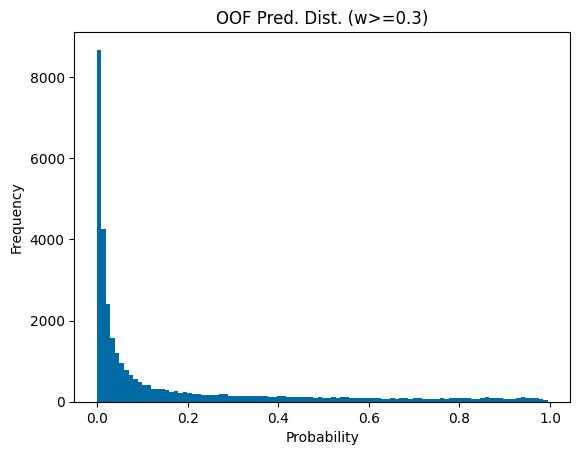

In [10]:
def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


oof_df_with_id = (
    pl.read_parquet("../data/pseudo_label/v5_eeg_24ep_cutmix/train_pseudo_label.pqt")
    .join(eeg_df_with_id.select("eeg_id"), on="eeg_id")
    .with_columns(
        pl.col(f"pl_{label}_vote").exp().alias(f"pl_{label}_vote") for label in LABELS
    )
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"pl_{label}_vote")
        for label in LABELS
    ).drop("pl_vote")
)
oof_df = oof_df_with_id.drop("eeg_id")
oof = oof_df.to_numpy()
oof = oof.flatten()
_, ax = plt.subplots()
ax.hist(oof, bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="OOF Pred. Dist. (w>=0.3)",
)
plt.show()

* モデルはGTラベルの数値の統計分布を捉えきれていないので、補正のPPはそれなりに効きそう

### Max/Min dist

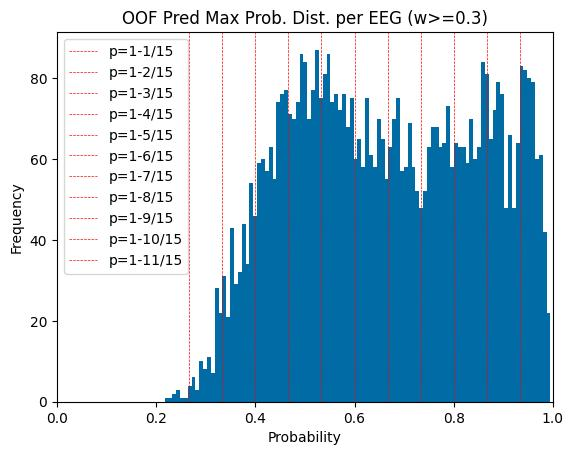

In [11]:
_, ax = plt.subplots()
ax.hist(oof_df.to_numpy().max(axis=1), bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="OOF Pred Max Prob. Dist. per EEG (w>=0.3)",
    xlim=(0, 1),
)
for i in range(1, 12):
    ax.axvline(1-i/15, color="red", linestyle="--", label=f"p=1-{i}/15", linewidth=0.5)
ax.legend()
plt.show()

* maxのうち閾値超えるものを1に補正する

In [ ]:
_, ax = plt.subplots()
ax.hist(oof_df.to_numpy().min(axis=1), bins=100)
ax.set(
    xlabel="Probability",
    ylabel="Frequency",
    title="OOF Min Prob. Dist. per EEG (w>=0.3)",
    xlim=(0, 1),
)
plt.show()

* minのうち、閾値を下回るものを0で補正する

## 共通する課題

* KL-divは和を1にする必要があるので、補正した後の余りをどこに配分するか？という問題がある（他のクラスに等配分？）